In [168]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Domain and Parameters
L = 10  # Domain limit [-L, L] for x and y
n = 64  # Grid points in each direction
x = np.linspace(-L, L, n, endpoint=False)
y = np.linspace(-L, L, n, endpoint=False)
X, Y = np.meshgrid(x, y)

beta = 1
D1, D2 = 0.1, 0.1
tspan = (0, 4)  # Time span
dt = 0.5
timesteps = np.arange(tspan[0], tspan[1] + dt, dt)

# Initial conditions: One-armed spiral
m = 1  # Number of spirals
U0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

# Wavenumber arrays for FFT
kx = np.fft.fftfreq(n, d=(2 * L / n)) * 2 * np.pi
ky = np.fft.fftfreq(n, d=(2 * L / n)) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
Laplacian_fourier = -(KX**2 + KY**2)  # Fourier-domain Laplacian

# Fourier transforms of initial conditions
U0_hat = np.fft.fft2(U0)
V0_hat = np.fft.fft2(V0)

# Reaction-Diffusion RHS in Fourier space
def reaction_diffusion_rhs(t, uv_hat):
    U_hat = uv_hat[:n * n].reshape((n, n))
    V_hat = uv_hat[n * n:].reshape((n, n))
    
    # Transform back to physical space
    U = np.fft.ifft2(U_hat).real
    V = np.fft.ifft2(V_hat).real
    
    # Compute A² = U² + V²
    A2 = U**2 + V**2
    
    # Compute λ(A) and ω(A)
    Lambda = 1 - A2
    Omega = -beta * A2
    
    # Reaction terms
    reaction_U = Lambda * U - Omega * V
    reaction_V = Omega * U + Lambda * V
    
    # Diffusion terms in Fourier space
    diffusion_U = D1 * Laplacian_fourier * U_hat
    diffusion_V = D2 * Laplacian_fourier * V_hat
    
    # Combine reaction and diffusion
    dUdt_hat = np.fft.fft2(reaction_U) + diffusion_U
    dVdt_hat = np.fft.fft2(reaction_V) + diffusion_V
    
    return np.concatenate([dUdt_hat.ravel(), dVdt_hat.ravel()])

# Solve the system in Fourier space
uv0_hat = np.concatenate([U0_hat.ravel(), V0_hat.ravel()])
sol = solve_ivp(
    reaction_diffusion_rhs,
    tspan,
    uv0_hat,
    t_eval=timesteps,
    method='RK45',
    vectorized=False
)

# Extract solutions (Fourier coefficients)
solutions = sol.y
A1 = solutions  # Fourier-domain solution

# Visualization
# Visualization
# fig, ax = plt.subplots(figsize=(6, 6))
# initial_U = np.fft.ifft2(A1[:n * n, 0].reshape((n, n))).real
# im = ax.imshow(initial_U, cmap='coolwarm', origin='lower', extent=[-L, L, -L, L])
# ax.set_title('Reaction-Diffusion System')
# plt.colorbar(im, ax=ax)

# def update(frame):
#     U_hat = A1[:n * n, frame].reshape((n, n))
#     U = np.fft.ifft2(U_hat).real  # Convert back to physical space and extract the real part
#     im.set_array(U)
#     ax.set_title(f'Time = {timesteps[frame]:.2f}')
#     return [im]

# ani = FuncAnimation(fig, update, frames=len(timesteps), blit=True)
# ani.save('reaction_diffusion_fft.gif', fps=10)


In [166]:
A1

array([[ 24.94003847  +0.j        ,  12.73268299  +0.j        ,
         -1.38095598  +0.j        , ..., -64.02389647  +0.j        ,
        -67.76356741  +0.j        , -61.18058974  +0.j        ],
       [-18.55666362 -58.16631091j, -42.51586944 -46.91292244j,
        -60.80795253 -25.74803902j, ..., -26.39439597+113.08288984j,
          6.86544434+123.00045628j,  41.4436393 +110.05531209j],
       [-16.04755868 +32.82798293j, -22.03971648 -45.79777396j,
        -23.23089505-104.14171583j, ..., -25.03391682 -92.65273136j,
        -29.2936105  -40.95948731j, -31.3712619  +15.69868908j],
       ...,
       [ 24.73021466-566.77472255j,  34.94179045-331.37291658j,
         38.82924248 -49.7842318j , ...,   4.99619196+602.39629491j,
         -9.93322885+490.73690642j, -25.6299042 +281.79202092j],
       [ 25.33720124-361.63379183j,  43.00958768-453.71174572j,
         51.93221654-447.84156197j, ..., -30.76392977+266.44218727j,
        -58.45411318+429.16535845j, -74.0191717 +505.3153223j ]

MovieWriter ffmpeg unavailable; using Pillow instead.


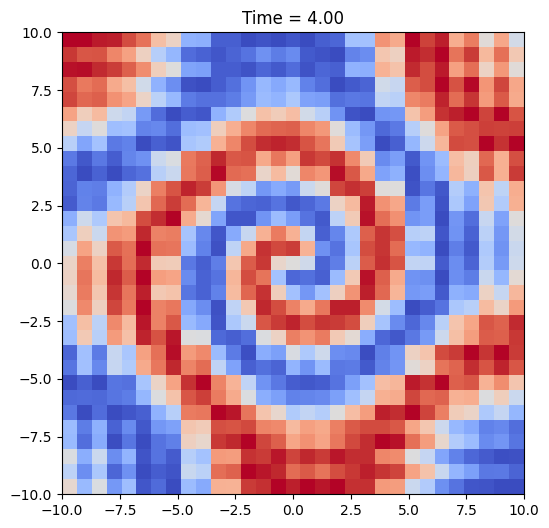

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.linalg import kron
from scipy.integrate import solve_ivp
from PIL import Image

# Function to create the Chebyshev grid and differentiation matrix
def cheb(N):
    if N == 0:
        D = 0.0
        x = 1.0
    else:
        n = np.arange(0, N + 1)
        x = np.cos(np.pi * n / N).reshape(N + 1, 1)
        c = (np.hstack(([2.0], np.ones(N - 1), [2.0])) * (-1) ** n).reshape(N + 1, 1)
        X = np.tile(x, (1, N + 1))
        dX = X - X.T
        D = (c @ (1.0 / c.T)) / (dX + np.eye(N + 1))
        D -= np.diag(np.sum(D.T, axis=0))

    return D, x.reshape(N + 1)

# Parameters
N = 30  # Grid size
a, b = -10, 10  # Domain limits
D, x_cheb = cheb(N)  # Get the Chebyshev grid and differentiation matrix
x = 0.5 * (b - a) * (x_cheb + 1) + a
D[N, :] = 0  # Boundary conditions
D[0, :] = 0
D_2 = (np.dot(D, D)) / ((0.5 * (b - a))**2)
y = x  # Use the same grid for y
I = np.eye(len(D_2))

# 2D Laplacian
L = kron(I, D_2) + kron(D_2, I)

# Meshgrid for plotting
X, Y = np.meshgrid(x, y)

# Initial conditions (spiral pattern)
m = 1
beta = 1
D1, D2 = 0.1, 0.1
U = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

# Function to compute the reaction-diffusion RHS
def reaction_diffusion_rhs(t, uv):
    U, V = uv[:len(uv) // 2], uv[len(uv) // 2:]
    Asq = U**2 + V**2
    lambda_ = 1 - Asq
    omega = -beta * Asq
    dUdt = lambda_ * U - omega * V + D1 * L @ U
    dVdt = omega * U + lambda_ * V + D2 * L @ V
    return np.hstack([dUdt, dVdt])

# Initial conditions and parameters
D1 = D2 = 0.1
beta = 1.0
uv0 = np.hstack([U.ravel(), V.ravel()])

# Time integration using solve_ivp
tspan = (0, 4)  # Time span
timesteps = np.arange(tspan[0], tspan[1] + 0.5, 0.5)  # Time points
sol = solve_ivp(
    reaction_diffusion_rhs, 
    tspan, 
    uv0, 
    t_eval=timesteps, 
    method='RK45', 
    vectorized=False
)

# Extract solutions
solutions = sol.y
timesteps = sol.t

A2 = solutions
# Create the animation
# fig, ax = plt.subplots(figsize=(6, 6))
# U0 = A2[:(N + 1)**2, 0].reshape(N + 1, N + 1)  # Initial U at t=0
# im = ax.imshow(U0, cmap='coolwarm', origin='lower', extent=[-b, b, -b, b])
# ax.set_title('Reaction-Diffusion System')

# def update(frame):
#     # Reshape the U field at the current time step
#     U = A2[:(N + 1)**2, frame].reshape(N + 1, N + 1)
#     im.set_array(U)
#     ax.set_title(f'Time = {timesteps[frame]:.2f}')
#     return [im]

# ani = FuncAnimation(fig, update, frames=len(timesteps), blit=True)
# ani.save('reaction_diffusion_cheb.gif', fps=10)

In [191]:
A2

array([[ 0.70358468,  0.27678435, -0.21775865, ..., -0.79689015,
        -0.40972859,  0.07776933],
       [ 0.73241275,  0.47188952,  0.07344742, ..., -0.96577657,
        -0.78500366, -0.4261521 ],
       [ 0.81058026,  0.37605887, -0.11123233, ..., -0.84008598,
        -0.49565779, -0.03085913],
       ...,
       [ 0.58562756,  0.91352592,  0.97914313, ..., -0.50294695,
        -0.84298442, -0.97634716],
       [ 0.6808609 ,  0.87018536,  0.97997159, ..., -0.16453512,
        -0.5878894 , -0.88455009],
       [ 0.71061143,  0.96093661,  0.97601586, ..., -0.60413504,
        -0.91222169, -0.99697897]])